In [2]:
import json
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

In [3]:
DATA_DIR = Path("data/question_1c")

In [8]:
import gurobipy as gp
from gurobipy import GRB


class InputData:
    def __init__(self, VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense):
        self.VARIABLES = VARIABLES
        self.objective_coeff = objective_coeff
        self.constraints_coeff = constraints_coeff
        self.constraints_rhs = constraints_rhs
        self.constraints_sense = constraints_sense

class LP_OptimizationProblem:

    def __init__(self, input_data: InputData): 
        self.data = input_data 
        self.results = type("Expando", (), {})()  # simple dummy expando
        self._build_model() 
    
    def _build_variables(self):
        self.variables = {v: self.model.addVar(lb=0, name=v) for v in self.data.VARIABLES}
    
    def _build_constraints(self):
        self.constraints = []
        for i in range(len(self.data.constraints_rhs)):
            lhs = gp.quicksum(self.data.constraints_coeff[v][i] * self.variables[v] for v in self.data.VARIABLES)
            constr = self.model.addLConstr(lhs,
                                           self.data.constraints_sense[i],
                                           self.data.constraints_rhs[i],
                                           name=f"constr[{i}]")
            self.constraints.append(constr)

    def _build_objective_function(self):
        objective = gp.quicksum(self.data.objective_coeff[v] * self.variables[v] for v in self.data.VARIABLES)
        self.model.setObjective(objective, GRB.MINIMIZE)

    def _build_model(self):
        self.model = gp.Model(name='Consumer Flexibility')
        self._build_variables()
        self._build_objective_function()
        self._build_constraints()
        self.model.update()
    
    def _save_results(self):
        self.results.objective_value = self.model.ObjVal
        self.results.variables = {v: self.variables[v].X for v in self.data.VARIABLES}
        self.results.duals = {f"constr[{i}]": self.constraints[i].Pi for i in range(len(self.constraints))}

    def run(self):
        self.model.optimize()
        if self.model.status == GRB.OPTIMAL:
            self._save_results()
        else:
            print(f"optimization of {self.model.ModelName} was not successful")
    
    def display_results(self):
        print("\n-------------------   RESULTS  -------------------")
        print("Optimal objective value:", self.results.objective_value)
        print("Optimal variable values:", self.results.variables)
        print("Optimal dual values:", self.results.duals)

In [13]:
def load_inputs(data_dir=DATA_DIR):
    with open(data_dir / "appliance_params.json") as f:
        appliance_params = json.load(f)
    with open(data_dir / "bus_params.json") as f:
        bus_params = json.load(f)[0]
    with open(data_dir / "consumer_params.json") as f:
        consumer_params = json.load(f)[0]
    with open(data_dir / "DER_production.json") as f:
        der_prod = json.load(f)[0]
    with open(data_dir / "usage_preferences.json") as f:  # Fixed filename
        usage_pref = json.load(f)[0]
    return appliance_params, bus_params, consumer_params, der_prod, usage_pref

def prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref):
    T = len(bus_params["energy_price_DKK_per_kWh"])
    price = np.array(bus_params["energy_price_DKK_per_kWh"])
    imp_tariff = np.full(T, bus_params["import_tariff_DKK/kWh"])
    exp_tariff = np.full(T, bus_params["export_tariff_DKK/kWh"])

    # PV parameters
    pv_power = next(d["max_power_kW"] for d in appliance_params["DER"] if d["DER_type"] == "PV")
    pv_profile = np.array(der_prod["hourly_profile_ratio"])
    P_pv = pv_power * pv_profile
    
    # Load parameters
    l_max_hour = next(l["max_load_kWh_per_hour"] for l in appliance_params["load"])
    
    # Calculate L_ref by multiplying the hourly ratio by the max hourly load
    load_prefs = usage_pref["load_preferences"][0]
    hourly_ratios = np.array(load_prefs["hourly_profile_ratio"])
    L_ref = hourly_ratios * l_max_hour
    
    # Battery storage parameters for Task 1c
    battery_params = {}
    if appliance_params["storage"] is not None:
        storage = appliance_params["storage"][0]  # Assume first storage device
        battery_params = {
            "capacity_kWh": storage["storage_capacity_kWh"],
            "max_charge_power_kW": storage["storage_capacity_kWh"] * storage["max_charging_power_ratio"],
            "max_discharge_power_kW": storage["storage_capacity_kWh"] * storage["max_discharging_power_ratio"],
            "charge_efficiency": storage["charging_efficiency"],
            "discharge_efficiency": storage["discharging_efficiency"]
        }
        
        # Battery preferences (initial and final SOC)
        storage_prefs = usage_pref["storage_preferences"][0]
        battery_params.update({
            "initial_soc_ratio": storage_prefs["initial_soc_ratio"],
            "final_soc_ratio": storage_prefs["final_soc_ratio"]
        })
    
    return dict(T=T, price=price, imp_tariff=imp_tariff, exp_tariff=exp_tariff,
                P_pv=P_pv, l_max_hour=l_max_hour, L_ref=L_ref, 
                battery_params=battery_params)

def make_scenarios(base):
    scenarios = {}
    # Base
    scenarios["Base"] = dict(price=base["price"], imp=base["imp_tariff"], exp=base["exp_tariff"])
    # Constant price
    scenarios["Const price"] = dict(price=np.full(base["T"], base["price"].mean()),
                                    imp=base["imp_tariff"], exp=base["exp_tariff"])
    # Net metering
    scenarios["Net metering"] = dict(price=base["price"], imp=np.zeros(base["T"]), exp=np.zeros(base["T"]))
    # No profitable export
    scenarios["No export"] = dict(price=base["price"], imp=base["imp_tariff"],
                                  exp=base["price"]+0.01)
    # Evening spike
    spike = base["price"].copy()
    spike[18:22] *= 2.0
    scenarios["Spike"] = dict(price=spike, imp=base["imp_tariff"], exp=base["exp_tariff"])
    return scenarios

def results_to_dataframe(results, T):
    """
    Convert solver results into a DataFrame of time-series variables.
    Handles both indexed (x[t]) and scalar variables (like E_cap).
    """
    df = pd.DataFrame(index=range(T))

    scalar_vars = {}  # store non-time-dependent variables

    for var, value in results.variables.items():
        if "[" in var:
            name, idx = var.split("[")
            t = int(idx.strip("]"))
            df.loc[t, name] = value
        else:
            scalar_vars[var] = value  # e.g. "E_cap"

    df = df.fillna(0)

    # Optional: attach scalar variables as metadata
    for name, val in scalar_vars.items():
        df.attrs[name] = val

    return df

def plot_hourly_flows_with_prices(df, scenario_name, duals=None,
                                  price=None, alpha=None, beta=None, L_ref=None, # NEW: Add L_ref
                                  ylim=(0,6.5),
                                  show_battery=True):
    rename = {
        "l": "Load",
        "p": "PV to bus",
        "e": "Grid imports",
        "s": "PV exported",
        "c": "PV curtailed",
        "d+": "Upward deviation",
        "d-": "Downward deviation",
        "b_ch": "Battery charge",
        "b_dis": "Battery discharge",
        "soc": "Battery SOC"
    }
    df_named = df.rename(columns=rename)

    # Compute total PV generation
    df_named["PV generation"] = (
        df_named.get("PV to bus", 0)
        + df_named.get("PV exported", 0)
        + df_named.get("PV curtailed", 0)
    )

    hours = df_named.index
    width = 0.25
    bar_alpha = 0.85

    plt.rcParams.update({
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    })

    fig, ax1 = plt.subplots(figsize=(14,6))

    # --- Group 1: PV generation (stacked) ---
    ax1.bar(hours - width, df_named["PV to bus"], width,
            label="PV to bus", color="gold", alpha=bar_alpha)
    ax1.bar(hours - width, df_named["PV exported"], width,
            bottom=df_named["PV to bus"], label="PV exported",
            color="forestgreen", alpha=bar_alpha)
    ax1.bar(hours - width, df_named["PV curtailed"], width,
            bottom=df_named["PV to bus"]+df_named["PV exported"],
            label="PV curtailed", color="lightgray", alpha=bar_alpha)

    # --- PV frame (outline for total generation) ---
    ax1.bar(hours - width, df_named["PV generation"], width,
            fill=False, edgecolor="black", linewidth=0.5,
            label="Total PV generation")

    # --- Group 2: Load with deviations and battery charge stacked on top ---
    base_load = df_named["Load"]
    ax1.bar(hours, base_load, width,
            label="Load", color="royalblue", alpha=bar_alpha)
    
    # Stack upward deviation on top of load
    ax1.bar(hours, df_named.get("Upward deviation", 0), width,
            bottom=base_load, label="Upward deviation", color="cyan", alpha=bar_alpha)
    
    # Stack downward deviation on top of load + upward deviation
    ax1.bar(hours, df_named.get("Downward deviation", 0), width,
            bottom=base_load + df_named.get("Upward deviation", 0), 
            label="Downward deviation", color="magenta", alpha=bar_alpha)
    
    # Stack battery charge on top of everything else in the load bar
    total_deviations = df_named.get("Upward deviation", 0) + df_named.get("Downward deviation", 0)
    ax1.bar(hours, df_named.get("Battery charge", 0), width,
            bottom=base_load + total_deviations,
            label="Battery charge", color="deepskyblue", alpha=bar_alpha)

    # --- Group 3: Imports with battery discharge stacked on top ---
    base_imports = df_named["Grid imports"]
    ax1.bar(hours + width, base_imports, width,
            label="Grid imports", color="firebrick", alpha=bar_alpha)
    
    # Stack battery discharge on top of imports
    ax1.bar(hours + width, df_named.get("Battery discharge", 0), width,
            bottom=base_imports, label="Battery discharge", color="orange", alpha=bar_alpha)
    
    # --- Plot reference load as a line ---
    if L_ref is not None:
        ax1.plot(hours, L_ref, color='darkorange', linestyle='-', drawstyle='steps-mid',
         linewidth=2.5, label='Reference Load')

    # --- Battery SOC line (only if showing battery) ---
    if show_battery and "Battery SOC" in df_named.columns:
        ax1.plot(hours, df_named["Battery SOC"], color="black", linestyle="--", 
                 linewidth=2, label="Battery SOC (kWh)")

    # --- Axis formatting ---
    ax1.set_title(f"Energy flows and prices – {scenario_name}")
    ax1.set_xlabel("Hour of day")
    ax1.set_ylabel("Energy (kWh)")
    ax1.set_ylim(ylim)
    ax1.set_xlim(-0.5, len(hours)-0.5)
    ax1.set_xticks(range(len(hours)))
    ax1.grid(True, which="both", axis="y", linestyle="--", alpha=0.6)

    # --- Second axis: prices ---
    if duals is not None:
        ax2 = ax1.twinx()
        p_int = -pd.Series(duals, index=hours)   # flip sign for internal price
        ax2.plot(hours, p_int, marker="x", linestyle="--",
                 color="purple", linewidth=2, label="Internal price (−λ)")

        if price is not None:
            ax2.plot(hours, price, marker="o", linestyle=":",
                     color="dimgray", linewidth=2, label="Market price π")
        """
        if alpha is not None:
            ax2.plot(hours, alpha, linestyle="--",
                     color="red", linewidth=2, label="Import cost α")
        if beta is not None:
            ax2.plot(hours, beta, linestyle="-.",
                     color="green", linewidth=2, label="Export value β")
        """

        ax2.set_ylabel("Price (DKK/kWh)")
        ax2.tick_params(axis='y', labelcolor="black")

        # Merge legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1+lines2, labels1+labels2,
                   loc="upper center", bbox_to_anchor=(0.5, -0.18),
                   ncol=5, frameon=False)
    else:
        ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18),
                   ncol=5, frameon=False)

    plt.tight_layout()
    plt.show()

In [54]:
def build_input_data_2b(base, scenario, C_batt, r_ch, r_dis, s0=0.5, sT=0.5, 
                        gamma_up=0.8, gamma_down=0.8):
    """
    Extended input builder for Task 2(b) – joint investment and operational optimization.

    Adds the investment decision variable E_cap (battery capacity)
    and scales all relevant constraints accordingly.

    Parameters
    ----------
    base : dict
        Base data with keys: "T", "P_pv", "l_max_hour", "L_ref", "battery_params"
    scenario : dict
        Scenario data with keys: "price", "imp", "exp"
    C_batt : float
        Specific capital cost of the battery (DKK/kWh)
    r_ch, r_dis : float
        Max charge/discharge power ratios (kW per kWh of capacity)
    s0, sT : float, optional
        Initial and final SoC ratios (default 0.5 each)
    gamma_up, gamma_down : float, optional
        Discomfort cost multipliers for upward and downward deviations (default 1.0 each)
        These multiply the price to create the discomfort penalty
    """

    # --- Extract data ---
    T = base["T"]
    price = scenario["price"]
    imp = scenario["imp"]
    exp = scenario["exp"]
    P_pv = base["P_pv"]
    l_max_hour = base["l_max_hour"]
    L_ref = base["L_ref"]
    battery = base["battery_params"]

    eta_ch = battery["charge_efficiency"]
    eta_dis = battery["discharge_efficiency"]

    # --- Variable list ---
    VARIABLES = ["E_cap"]  # new investment variable
    for t in range(T):
        VARIABLES += [
            f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]",
            f"d+[{t}]", f"d-[{t}]",
            f"b_ch[{t}]", f"b_dis[{t}]", f"soc[{t}]"
        ]

    # --- Objective coefficients ---
    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        # 10 years * 365 days = 3650 cycles
        objective_coeff[f"e[{t}]"] = 3650 * (price[t] + imp[t])
        objective_coeff[f"s[{t}]"] = -3650 * (price[t] - exp[t])
        objective_coeff[f"d+[{t}]"] = 3650 * price[t] * gamma_up
        objective_coeff[f"d-[{t}]"] = 3650 * price[t] * gamma_down
    # CAPEX term
    objective_coeff["E_cap"] = C_batt

    # --- Initialize constraints containers ---
    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # (1) Main energy balance: l + b_ch = p + e + b_dis * η_dis
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"b_ch[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            elif v == f"b_dis[{t}]": coeff = -eta_dis
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (2) PV split: p + s + c + b_ch = P_pv
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            elif v == f"b_ch[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    # (3) Max load limit
    for t in range(T):
        for v in VARIABLES:
            coeff = 1.0 if v == f"l[{t}]" else 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(l_max_hour)
        constraints_sense.append(GRB.LESS_EQUAL)

    # (4) Load deviation: l - d+ + d- = L_ref
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"d+[{t}]": coeff = -1.0
            elif v == f"d-[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(L_ref[t])
        constraints_sense.append(GRB.EQUAL)

    # (5) Battery SoC dynamics
    for t in range(T):
        for v in VARIABLES:
            if v == f"soc[{t}]": coeff = 1.0
            elif v == f"soc[{t-1}]": coeff = -1.0 if t > 0 else 0.0
            elif v == f"b_ch[{t}]": coeff = -eta_ch
            elif v == f"b_dis[{t}]": coeff = 1.0 / eta_dis
            elif v == "E_cap": coeff = -s0 if t == 0 else 0.0  # initial scaling
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (6) Capacity limit: soc_t ≤ E_cap
    for t in range(T):
        for v in VARIABLES:
            if v == f"soc[{t}]": coeff = 1.0
            elif v == "E_cap": coeff = -1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.LESS_EQUAL)

    # (7) Power limits (scale with E_cap)
    for t in range(T):
        # charge
        for v in VARIABLES:
            if v == f"b_ch[{t}]": coeff = 1.0
            elif v == "E_cap": coeff = -r_ch
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.LESS_EQUAL)
        # discharge
        for v in VARIABLES:
            if v == f"b_dis[{t}]": coeff = 1.0
            elif v == "E_cap": coeff = -r_dis
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.LESS_EQUAL)

    # (8) End-of-day SoC: soc_T = sT * E_cap
    for v in VARIABLES:
        if v == f"soc[{T-1}]": coeff = 1.0
        elif v == "E_cap": coeff = -sT
        else: coeff = 0.0
        constraints_coeff[v].append(coeff)
    constraints_rhs.append(0.0)
    constraints_sense.append(GRB.EQUAL)

    # --- Return InputData object ---
    return InputData(VARIABLES, objective_coeff, constraints_coeff,
                     constraints_rhs, constraints_sense)

In [130]:
# Load inputs and prepare base data
appliance_params, bus_params, consumer_params, der_prod, usage_pref = load_inputs()
base = prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref)
scenarios = make_scenarios(base)

In [131]:
# Example parameters
C_batt = 200      # DKK/kWh
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']

input_data = build_input_data_2b(base, scenarios["Base"], C_batt, r_ch, r_dis)
problem = LP_OptimizationProblem(input_data)
problem.run()

# Extract results
df_results = results_to_dataframe(problem.results, base["T"])
print(f"Optimal capacity: {problem.results.variables['E_cap']:.2f} kWh")
print(f"Objective value: {problem.results.objective_value:.2f} DKK")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x11340363
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 7
      71    6.9761626e+04   0.000000e+00   0.000000e+00      0s

Solved in 71 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.976162600e+04
Optimal capacity: 4.70 kWh
Objective value: 69761.63 DKK


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x78535ea2
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 9
      71    1.0417138e+05   0.000000e+00   0.000000e+00      0s

Solved in 71 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.041713830e+05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 

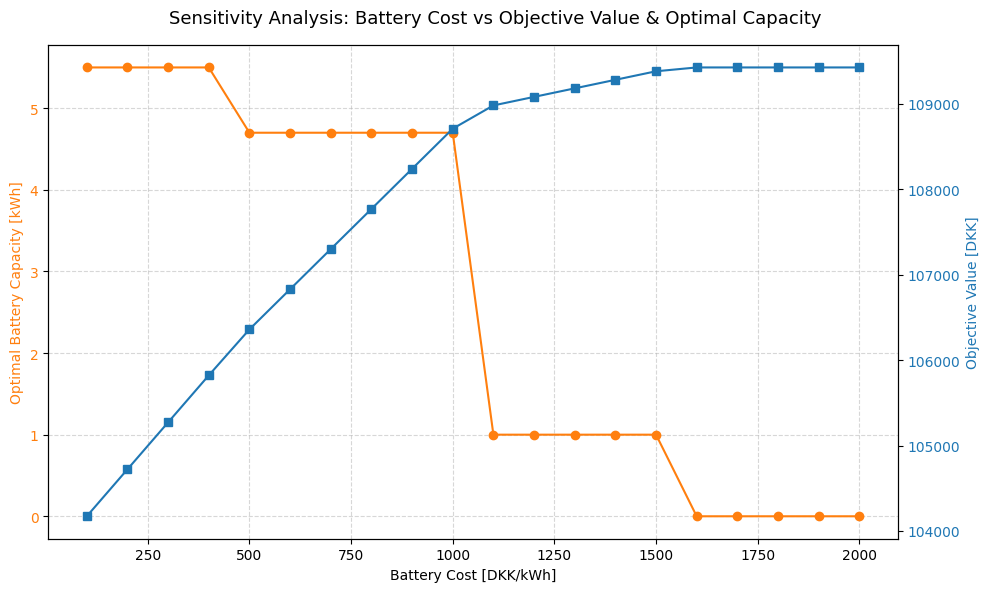

Battery cost:  100 DKK/kWh  |  E_cap*:  5.50 kWh  |  Objective: 104171.38 DKK
Battery cost:  200 DKK/kWh  |  E_cap*:  5.50 kWh  |  Objective: 104721.38 DKK
Battery cost:  300 DKK/kWh  |  E_cap*:  5.50 kWh  |  Objective: 105271.38 DKK
Battery cost:  400 DKK/kWh  |  E_cap*:  5.50 kWh  |  Objective: 105821.38 DKK
Battery cost:  500 DKK/kWh  |  E_cap*:  4.70 kWh  |  Objective: 106359.89 DKK
Battery cost:  600 DKK/kWh  |  E_cap*:  4.70 kWh  |  Objective: 106829.89 DKK
Battery cost:  700 DKK/kWh  |  E_cap*:  4.70 kWh  |  Objective: 107299.89 DKK
Battery cost:  800 DKK/kWh  |  E_cap*:  4.70 kWh  |  Objective: 107769.89 DKK
Battery cost:  900 DKK/kWh  |  E_cap*:  4.70 kWh  |  Objective: 108239.89 DKK
Battery cost: 1000 DKK/kWh  |  E_cap*:  4.70 kWh  |  Objective: 108709.89 DKK
Battery cost: 1100 DKK/kWh  |  E_cap*:  1.00 kWh  |  Objective: 108982.42 DKK
Battery cost: 1200 DKK/kWh  |  E_cap*:  1.00 kWh  |  Objective: 109082.42 DKK
Battery cost: 1300 DKK/kWh  |  E_cap*:  1.00 kWh  |  Objective: 

In [132]:
# --- Sensitivity Analysis: Battery cost vs Optimal Capacity ---

# Get parameters
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']

# Range of battery investment costs (DKK/kWh)
battery_costs = np.arange(100, 2001, 100)   # from 100 to 2000 DKK/kWh

# Prepare storage for results
optimal_capacities = []
objective_values = []

# Loop over battery costs
for C_batt in battery_costs:
    input_data = build_input_data_2b(base, scenarios["Base"], C_batt, r_ch, r_dis, gamma_down=1.2, gamma_up=1.2)
    problem = LP_OptimizationProblem(input_data)
    problem.run()

    if hasattr(problem.results, "objective_value"):
        optimal_capacities.append(problem.results.variables["E_cap"])
        objective_values.append(problem.results.objective_value)
    else:
        optimal_capacities.append(np.nan)
        objective_values.append(np.nan)

# --- Plot results ---
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(battery_costs, optimal_capacities, color="tab:orange", marker="o", label="Optimal Capacity (kWh)")
ax1.set_xlabel("Battery Cost [DKK/kWh]")
ax1.set_ylabel("Optimal Battery Capacity [kWh]", color="tab:orange")
ax1.tick_params(axis='y', labelcolor="tab:orange")
ax1.grid(True, linestyle="--", alpha=0.5)

# Secondary y-axis for objective value
ax2 = ax1.twinx()
ax2.plot(battery_costs, objective_values, color="tab:blue", marker="s", label="Objective Value (DKK)")
ax2.set_ylabel("Objective Value [DKK]", color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")

# Add title and formatting
fig.suptitle("Sensitivity Analysis: Battery Cost vs Objective Value & Optimal Capacity", fontsize=13)
fig.tight_layout()
plt.show()

# --- Print summary ---
for C_batt, E_cap, obj in zip(battery_costs, optimal_capacities, objective_values):
    print(f"Battery cost: {C_batt:4.0f} DKK/kWh  |  E_cap*: {E_cap:5.2f} kWh  |  Objective: {obj:8.2f} DKK")

In [135]:
from mpl_toolkits.mplot3d import Axes3D

# --- Parameters ---
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']

# Sweep ranges
battery_costs = np.arange(100, 2001, 200)          # DKK/kWh
discomfort_factors = np.arange(0.5, 1.6, 0.1)      # gamma multiplier (1.0 = no discomfort, higher = stricter)

# Prepare storage for results
E_cap_matrix = np.zeros((len(discomfort_factors), len(battery_costs)))
Obj_matrix = np.zeros_like(E_cap_matrix)

# --- Double Loop ---
for i, gamma in enumerate(discomfort_factors):
    for j, C_batt in enumerate(battery_costs):
        input_data = build_input_data_2b(
            base,
            scenarios["Base"],
            C_batt,
            r_ch,
            r_dis,
            gamma_down=gamma,
            gamma_up=gamma
        )
        problem = LP_OptimizationProblem(input_data)
        problem.run()

        if hasattr(problem.results, "objective_value"):
            E_cap_matrix[i, j] = problem.results.variables["E_cap"]
            Obj_matrix[i, j] = problem.results.objective_value
        else:
            E_cap_matrix[i, j] = np.nan
            Obj_matrix[i, j] = np.nan

# # --- 3D Surface Plot for Optimal Capacity ---
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')

# X, Y = np.meshgrid(battery_costs, discomfort_factors)
# surf = ax.plot_surface(X, Y, E_cap_matrix, cmap='viridis', edgecolor='none')

# ax.set_xlabel("Battery Cost [DKK/kWh]")
# ax.set_ylabel("Discomfort Factor γ")
# ax.set_zlabel("Optimal Battery Capacity [kWh]")
# ax.set_title("3D Sensitivity: Optimal Battery Capacity vs Cost and Discomfort")
# fig.colorbar(surf, ax=ax, shrink=0.6, label="Optimal Capacity [kWh]")
# plt.show()

# # --- Optional: 2D Heatmap for Objective Value ---
# plt.figure(figsize=(8, 6))
# plt.imshow(Obj_matrix, aspect='auto', origin='lower', cmap='plasma',
#            extent=[battery_costs.min(), battery_costs.max(),
#                    discomfort_factors.min(), discomfort_factors.max()])
# plt.colorbar(label="Objective Value [DKK]")
# plt.xlabel("Battery Cost [DKK/kWh]")
# plt.ylabel("Discomfort Factor γ")
# plt.title("Objective Value Heatmap")
# plt.show()

# --- Print summary at selected points ---
for i, gamma in enumerate(discomfort_factors):
    best_idx = np.nanargmin(Obj_matrix[i])
    best_Cbatt = battery_costs[best_idx]
    print(f"γ={gamma:.2f} → Best cost {best_Cbatt} DKK/kWh, E_cap={E_cap_matrix[i,best_idx]:.2f} kWh, Obj={Obj_matrix[i,best_idx]:.2f}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x4e55b73a
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
      47    3.1856561e+04   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.185656125e+04
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, usin

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x4e55b73a
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
      47    3.1856561e+04   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.185656125e+04
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, usin

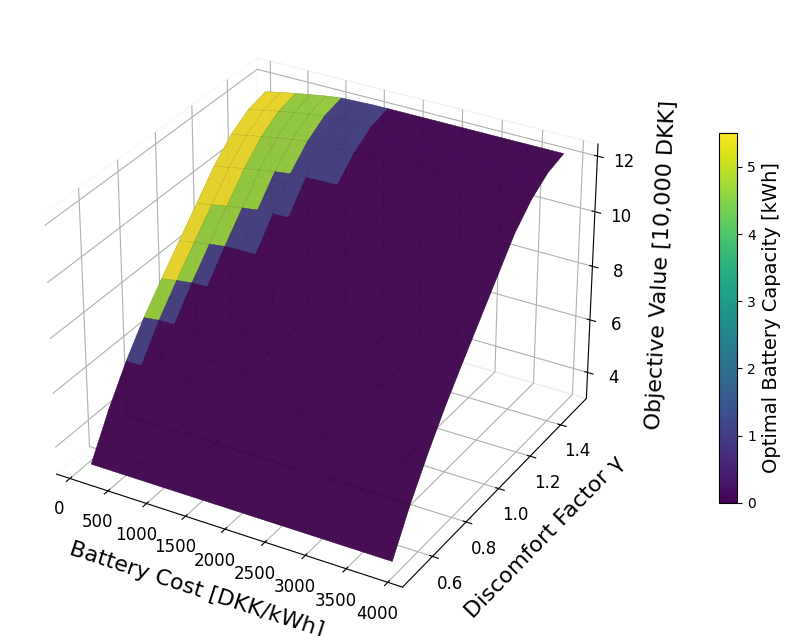

In [184]:
scenario_name = "Base"
# --- Parameters ---
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']

# Sweep ranges
battery_costs = np.arange(100, 4001, 200)          # DKK/kWh
discomfort_factors = np.arange(0.5, 1.6, 0.1)      # gamma multiplier (1.0 = no discomfort, higher = stricter)

# Prepare storage for results
E_cap_matrix = np.zeros((len(discomfort_factors), len(battery_costs)))
Obj_matrix = np.zeros_like(E_cap_matrix)

# --- Double Loop ---
for i, gamma in enumerate(discomfort_factors):
    for j, C_batt in enumerate(battery_costs):
        input_data = build_input_data_2b(
            base,
            scenarios[scenario_name],
            C_batt,
            r_ch,
            r_dis,
            gamma_down=gamma,
            gamma_up=gamma
        )
        problem = LP_OptimizationProblem(input_data)
        problem.run()

        if hasattr(problem.results, "objective_value"):
            E_cap_matrix[i, j] = problem.results.variables["E_cap"]
            Obj_matrix[i, j] = problem.results.objective_value
        else:
            E_cap_matrix[i, j] = np.nan
            Obj_matrix[i, j] = np.nan

X, Y = np.meshgrid(battery_costs, discomfort_factors)
Z = Obj_matrix
C = E_cap_matrix

# --- Scale Z axis to 10,000 DKK ---
Z_scaled = Z / 10000

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    X, Y, Z_scaled,
    facecolors=cm.viridis((C - np.nanmin(C)) / (np.nanmax(C) - np.nanmin(C))),
    rstride=1, cstride=1,
    linewidth=0.3, antialiased=True, shade=True,
    alpha=0.95
)

mappable = cm.ScalarMappable(cmap='viridis')
mappable.set_array(C)
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('Optimal Battery Capacity [kWh]', fontsize=14)

ax.set_xlabel("Battery Cost [DKK/kWh]", labelpad=10, fontsize=16)
ax.set_ylabel("Discomfort Factor γ", labelpad=10, fontsize=16)
ax.set_zlabel("Objective Value [10,000 DKK]", labelpad=10, fontsize=16)
#ax.set_title(f'{scenario_name} Scenario', fontsize=20)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(color='gray', linestyle='--', linewidth=0.4, alpha=0.4)
ax.plot_wireframe(X, Y, Z_scaled, color='k', linewidth=0.2, alpha=0.3)

plt.show()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x75ea65fc
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3561925e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 7
      68    3.7048348e+04   0.000000e+00   0.000000e+00      0s

Solved in 68 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.704834798e+04
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 

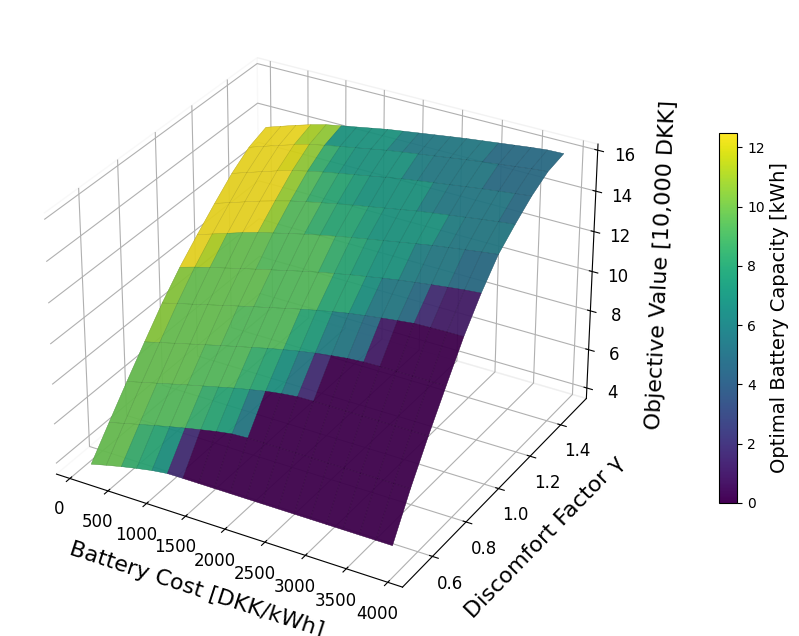

In [183]:
scenario_name = "Spike"
# --- Parameters ---
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']

# Sweep ranges
battery_costs = np.arange(100, 4001, 200)          # DKK/kWh
discomfort_factors = np.arange(0.5, 1.6, 0.1)      # gamma multiplier (1.0 = no discomfort, higher = stricter)

# Prepare storage for results
E_cap_matrix = np.zeros((len(discomfort_factors), len(battery_costs)))
Obj_matrix = np.zeros_like(E_cap_matrix)

# --- Double Loop ---
for i, gamma in enumerate(discomfort_factors):
    for j, C_batt in enumerate(battery_costs):
        input_data = build_input_data_2b(
            base,
            scenarios[scenario_name],
            C_batt,
            r_ch,
            r_dis,
            gamma_down=gamma,
            gamma_up=gamma
        )
        problem = LP_OptimizationProblem(input_data)
        problem.run()

        if hasattr(problem.results, "objective_value"):
            E_cap_matrix[i, j] = problem.results.variables["E_cap"]
            Obj_matrix[i, j] = problem.results.objective_value
        else:
            E_cap_matrix[i, j] = np.nan
            Obj_matrix[i, j] = np.nan

X, Y = np.meshgrid(battery_costs, discomfort_factors)
Z = Obj_matrix
C = E_cap_matrix

# --- Scale Z axis to 10,000 DKK ---
Z_scaled = Z / 10000

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    X, Y, Z_scaled,
    facecolors=cm.viridis((C - np.nanmin(C)) / (np.nanmax(C) - np.nanmin(C))),
    rstride=1, cstride=1,
    linewidth=0.3, antialiased=True, shade=True,
    alpha=0.95
)

mappable = cm.ScalarMappable(cmap='viridis')
mappable.set_array(C)
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('Optimal Battery Capacity [kWh]', fontsize=14)

ax.set_xlabel("Battery Cost [DKK/kWh]", labelpad=10, fontsize=16)
ax.set_ylabel("Discomfort Factor γ", labelpad=10, fontsize=16)
ax.set_zlabel("Objective Value [10,000 DKK]", labelpad=10, fontsize=16)
#ax.set_title(f'{scenario_name} Scenario', fontsize=20)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(color='gray', linestyle='--', linewidth=0.4, alpha=0.4)
ax.plot_wireframe(X, Y, Z_scaled, color='k', linewidth=0.2, alpha=0.3)

plt.show()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0xf38cf612
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [4e+01, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 93 columns
Presolve time: 0.00s
Presolved: 131 rows, 148 columns, 382 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.139315e+01   0.000000e+00      0s
      81    4.3725576e+04   0.000000e+00   0.000000e+00      0s

Solved in 81 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.372557625e+04
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, usin

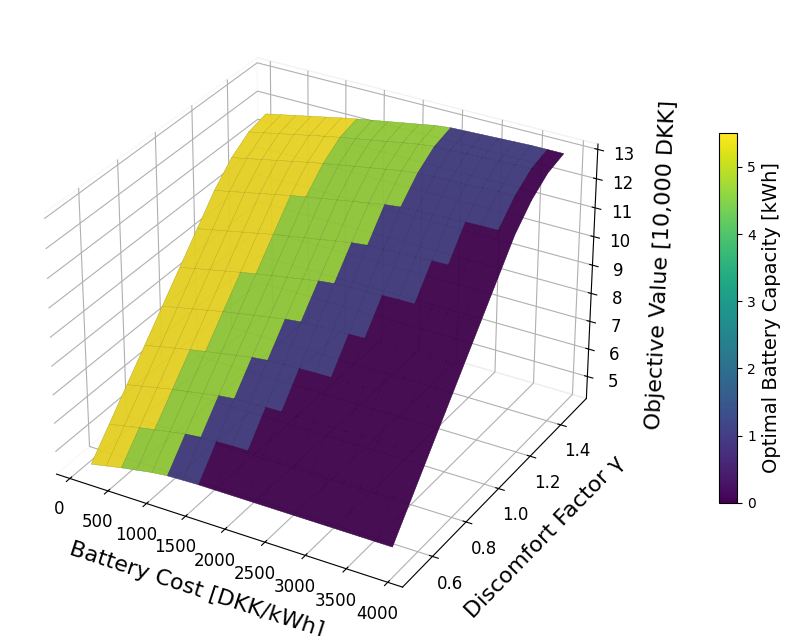

In [182]:
scenario_name = "No export"
# --- Parameters ---
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']

# Sweep ranges
battery_costs = np.arange(100, 4001, 200)          # DKK/kWh
discomfort_factors = np.arange(0.5, 1.6, 0.1)      # gamma multiplier (1.0 = no discomfort, higher = stricter)

# Prepare storage for results
E_cap_matrix = np.zeros((len(discomfort_factors), len(battery_costs)))
Obj_matrix = np.zeros_like(E_cap_matrix)

# --- Double Loop ---
for i, gamma in enumerate(discomfort_factors):
    for j, C_batt in enumerate(battery_costs):
        input_data = build_input_data_2b(
            base,
            scenarios[scenario_name],
            C_batt,
            r_ch,
            r_dis,
            gamma_down=gamma,
            gamma_up=gamma
        )
        problem = LP_OptimizationProblem(input_data)
        problem.run()

        if hasattr(problem.results, "objective_value"):
            E_cap_matrix[i, j] = problem.results.variables["E_cap"]
            Obj_matrix[i, j] = problem.results.objective_value
        else:
            E_cap_matrix[i, j] = np.nan
            Obj_matrix[i, j] = np.nan

X, Y = np.meshgrid(battery_costs, discomfort_factors)
Z = Obj_matrix
C = E_cap_matrix

# --- Scale Z axis to 10,000 DKK ---
Z_scaled = Z / 10000

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    X, Y, Z_scaled,
    facecolors=cm.viridis((C - np.nanmin(C)) / (np.nanmax(C) - np.nanmin(C))),
    rstride=1, cstride=1,
    linewidth=0.3, antialiased=True, shade=True,
    alpha=0.95
)

mappable = cm.ScalarMappable(cmap='viridis')
mappable.set_array(C)
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('Optimal Battery Capacity [kWh]', fontsize=14)

ax.set_xlabel("Battery Cost [DKK/kWh]", labelpad=10, fontsize=16)
ax.set_ylabel("Discomfort Factor γ", labelpad=10, fontsize=16)
ax.set_zlabel("Objective Value [10,000 DKK]", labelpad=10, fontsize=16)
#ax.set_title(f'{scenario_name} Scenario', fontsize=20)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(color='gray', linestyle='--', linewidth=0.4, alpha=0.4)
ax.plot_wireframe(X, Y, Z_scaled, color='k', linewidth=0.2, alpha=0.3)

plt.show()

In [176]:
# --- Parameters ---
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']
gamma = 1
battery_costs = np.arange(100, 5001, 100)

scenario_names = ["Base", "Const price", "Net metering", "No export", "Spike"]
colors = plt.cm.tab10(np.linspace(0, 1, len(scenario_names)))

# --- Store results ---
results = {}

for name, color in zip(scenario_names, colors):
    optimal_capacities = []
    objective_values = []

    for C_batt in battery_costs:
        input_data = build_input_data_2b(base, scenarios[name], C_batt, r_ch, r_dis,
                                         gamma_down=gamma, gamma_up=gamma)
        problem = LP_OptimizationProblem(input_data)
        problem.run()

        if hasattr(problem.results, "objective_value"):
            optimal_capacities.append(problem.results.variables["E_cap"])
            objective_values.append(problem.results.objective_value)
        else:
            optimal_capacities.append(np.nan)
            objective_values.append(np.nan)

    results[name] = {"E_cap": optimal_capacities, "Obj": objective_values}

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x8fd25c38
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 8
      71    8.6901153e+04   0.000000e+00   0.000000e+00      0s

Solved in 71 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.690115250e+04
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 

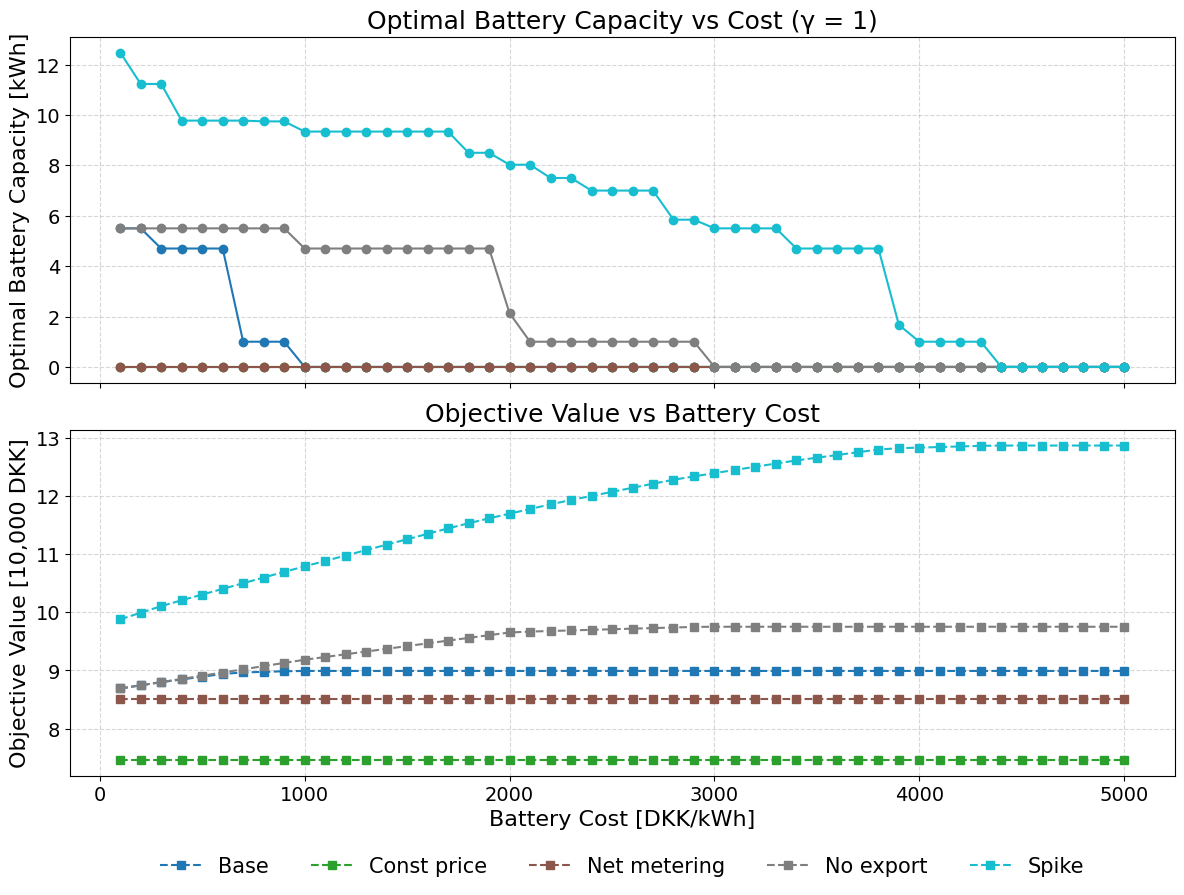

In [178]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

# Increase font sizes
font_size = 16
tick_size = 14
title_size = 18
legend_size = 15

ax1.set_ylabel("Optimal Battery Capacity [kWh]", fontsize=font_size)
ax1.set_title(f"Optimal Battery Capacity vs Cost (γ = {gamma})", fontsize=title_size)
ax1.tick_params(axis='both', labelsize=tick_size)

for name, color in zip(scenario_names, colors):
    ax1.plot(battery_costs, results[name]["E_cap"], marker="o", color=color, label=name)
ax1.grid(True, linestyle="--", alpha=0.5)

lines = []
labels = []
for name, color in zip(scenario_names, colors):
    obj_scaled = np.array(results[name]["Obj"]) / 10000
    line, = ax2.plot(battery_costs, obj_scaled, marker="s", ls="--", color=color, label=name)
    lines.append(line)
    labels.append(name)
ax2.set_xlabel("Battery Cost [DKK/kWh]", fontsize=font_size)
ax2.set_ylabel("Objective Value [10,000 DKK]", fontsize=font_size)
ax2.set_title("Objective Value vs Battery Cost", fontsize=title_size)
ax2.tick_params(axis='both', labelsize=tick_size)
ax2.grid(True, linestyle="--", alpha=0.5)

ax2.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.18), ncol=len(scenario_names), frameon=False, fontsize=legend_size)

fig.tight_layout()
plt.show()

In [185]:
def evaluate_profitability(base, scenario, C_batt_values, r_ch, r_dis, gamma=1.0):
    """Run sensitivity analysis over battery costs and compute profitability metrics."""
    daily_cost_no_batt = None
    results = []

    # First: run the model with zero battery capacity to get baseline daily cost
    input_data_no_batt = build_input_data_2b(base, scenario, C_batt=0, r_ch=r_ch, r_dis=r_dis,
                                             gamma_down=gamma, gamma_up=gamma)
    problem_no_batt = LP_OptimizationProblem(input_data_no_batt)
    problem_no_batt.run()
    daily_cost_no_batt = problem_no_batt.results.objective_value

    for C_batt in C_batt_values:
        input_data = build_input_data_2b(base, scenario, C_batt, r_ch, r_dis,
                                         gamma_down=gamma, gamma_up=gamma)
        problem = LP_OptimizationProblem(input_data)
        problem.run()

        if hasattr(problem.results, "objective_value"):
            E_cap = problem.results.variables["E_cap"]
            daily_cost_batt = problem.results.objective_value

            # --- Compute economic metrics ---
            CAPEX = C_batt * E_cap
            OPEX_batt = 3650 * daily_cost_batt
            OPEX_no_batt = 3650 * daily_cost_no_batt
            NPV = OPEX_no_batt - (CAPEX + OPEX_batt)
            annual_savings = 365 * (daily_cost_no_batt - daily_cost_batt)
            payback = CAPEX / annual_savings if annual_savings > 0 else np.nan

            results.append({
                "C_batt": C_batt,
                "E_cap": E_cap,
                "NPV": NPV,
                "payback": payback,
                "daily_cost_batt": daily_cost_batt
            })
        else:
            results.append({
                "C_batt": C_batt,
                "E_cap": np.nan,
                "NPV": np.nan,
                "payback": np.nan,
                "daily_cost_batt": np.nan
            })

    return pd.DataFrame(results)

In [186]:
evaluate_profitability(base, scenarios["Base"], np.arange(100, 4001, 100), r_ch, r_dis, gamma=1.0)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x04ec4d9e
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+03, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.01s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 8
      71    8.6351153e+04   0.000000e+00   0.000000e+00      0s

Solved in 71 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.635115250e+04
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 

,C_batt,E_cap,NPV,payback,daily_cost_batt
0,100,5.5,-2.008050e+06,NaN,86901.1525
1,200,5.5,-4.016100e+06,NaN,87451.1525
2,300,4.7,-5.983231e+06,NaN,87990.0075
3,400,4.7,-7.699201e+06,NaN,88460.0075
4,500,4.7,-9.415171e+06,NaN,88930.0075
5,600,4.7,-1.113114e+07,NaN,89400.0075
6,700,1.0,-1.208915e+07,NaN,89663.0560
7,800,1.0,-1.245425e+07,NaN,89763.0560
8,900,1.0,-1.281935e+07,NaN,89863.0560
9,1000,0.0,-1.303340e+07,NaN,89921.9475


In [187]:
evaluate_profitability(base, scenarios["Spike"], np.arange(100, 4001, 100), r_ch, r_dis, gamma=1.0)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0xbe174622
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+03, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3561925e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 10
      79    9.7544860e+04   0.000000e+00   0.000000e+00      0s

Solved in 79 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.754485985e+04
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8

,C_batt,E_cap,NPV,payback,daily_cost_batt
0,100,12.481481,-4.556989e+06,NaN,98793.007994
1,200,11.232000,-8.773127e+06,NaN,99947.840700
2,300,11.232000,-1.287393e+07,NaN,101071.040700
3,400,9.777778,-1.659248e+07,NaN,102089.674043
4,500,9.777778,-2.016235e+07,NaN,103067.451821
5,600,9.777778,-2.373222e+07,NaN,104045.229599
6,700,9.777778,-2.730208e+07,NaN,105023.007377
7,800,9.747000,-3.086320e+07,NaN,105998.393550
8,900,9.747000,-3.442183e+07,NaN,106973.093550
9,1000,9.342000,-3.786929e+07,NaN,107917.447800


In [188]:
def decompose_daily_costs(df, price, imp, exp, gamma_up=1.0, gamma_down=1.0):
    """
    Ex-post decompose the daily objective into:
      - cash_cost:      (price+imp)*e  - (price-exp)*s
      - discomfort_cost: gamma_up*price*d+ + gamma_down*price*d-
    df: dataframe of hourly variables (columns: e, s, d+, d-)
    price, imp, exp: arrays length T
    """
    e = df["e"].to_numpy() if "e" in df else 0
    s = df["s"].to_numpy() if "s" in df else 0
    d_up = df["d+"].to_numpy() if "d+" in df else 0
    d_dn = df["d-"].to_numpy() if "d-" in df else 0

    cash_cost = ((price + imp) * e - (price - exp) * s).sum()
    discomfort_cost = (gamma_up * price * d_up + gamma_down * price * d_dn).sum()
    total_objective = cash_cost + discomfort_cost

    return {
        "cash_cost": float(cash_cost),
        "discomfort_cost": float(discomfort_cost),
        "total_objective": float(total_objective),
    }


def evaluate_profitability_split(base, scenario, C_batt_values, r_ch, r_dis, gamma=1.0):
    """
    Returns a DataFrame with both cash-only and utility-adjusted metrics.
    Keeps gamma in the optimization (thus affecting schedules), but computes
    finances twice: with and without discomfort penalties.
    """
    T = base["T"]
    price = scenario["price"]
    imp = scenario["imp"]
    exp = scenario["exp"]

    # Baseline: run with same gamma but E_cap free to choose; then force E_cap=0 to get 'no battery'
    # (If you already have a guaranteed E_cap=0 run, reuse it)
    # No-battery baseline:
    scen0 = scenario.copy()
    # Trick: very high C_batt + same gamma → optimizer will pick E_cap=0
    input0 = build_input_data_2b(base, scen0, C_batt=1e6, r_ch=r_ch, r_dis=r_dis,
                                 gamma_down=gamma, gamma_up=gamma)
    prob0 = LP_OptimizationProblem(input0); prob0.run()
    df0 = results_to_dataframe(prob0.results, T)
    parts0 = decompose_daily_costs(df0, price, imp, exp, gamma_up=gamma, gamma_down=gamma)
    daily_cash0 = parts0["cash_cost"]
    daily_total0 = parts0["total_objective"]

    out_rows = []
    for C_batt in C_batt_values:
        inp = build_input_data_2b(base, scenario, C_batt, r_ch, r_dis,
                                  gamma_down=gamma, gamma_up=gamma)
        pr = LP_OptimizationProblem(inp); pr.run()
        df = results_to_dataframe(pr.results, T)
        parts = decompose_daily_costs(df, price, imp, exp, gamma_up=gamma, gamma_down=gamma)

        E_cap = float(pr.results.variables["E_cap"])
        CAPEX = C_batt * E_cap

        # --- Cash-only economics ---
        daily_cash = parts["cash_cost"]
        annual_savings_cash = 365 * (daily_cash0 - daily_cash)
        NPV_cash = 3650 * daily_cash0 - (CAPEX + 3650 * daily_cash)
        payback_cash = (CAPEX / annual_savings_cash) if annual_savings_cash > 0 else np.nan

        # --- Utility-adjusted economics (objective includes discomfort) ---
        daily_total = parts["total_objective"]
        NPV_total = 3650 * daily_total0 - (CAPEX + 3650 * daily_total)
        annual_savings_total = 365 * (daily_total0 - daily_total)
        payback_total = (CAPEX / annual_savings_total) if annual_savings_total > 0 else np.nan

        out_rows.append({
            "C_batt": C_batt,
            "E_cap": E_cap,

            # Cash-only economics
            "NPV_cash": NPV_cash,
            "payback_cash": payback_cash,
            "daily_cash": daily_cash,

            # Utility-adjusted economics
            "NPV_total": NPV_total,
            "payback_total": payback_total,
            "daily_total": daily_total,

            # Decomposition (per day)
            "cash_cost_day": parts["cash_cost"],
            "discomfort_cost_day": parts["discomfort_cost"],
        })

    return pd.DataFrame(out_rows)

In [189]:
C_batt_values = np.arange(100, 5001, 200)
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']

df_base = evaluate_profitability_split(base, scenarios["Base"], C_batt_values, r_ch, r_dis, gamma=1.2)
df_base.head()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x6088127c
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+03, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 2
      59    1.0942729e+05   0.000000e+00   0.000000e+00      0s

Solved in 59 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.094272920e+05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 

,C_batt,E_cap,NPV_cash,payback_cash,daily_cash,NPV_total,payback_total,daily_total,cash_cost_day,discomfort_cost_day
0,100,5.5,-8154.775,NaN,0.00000,5255.909,0.947311,28.38942,0.00000,28.38942
1,300,5.5,-16539.591,NaN,1.99584,4155.909,2.841932,28.38942,1.99584,26.39358
2,500,4.7,-9385.375,NaN,-0.15600,3067.403,4.337872,28.49586,-0.15600,28.65186
3,700,4.7,-10325.375,NaN,-0.15600,2127.403,6.073021,28.49586,-0.15600,28.65186
4,900,4.7,-19508.097,NaN,2.10228,1187.403,7.808169,28.49586,2.10228,26.39358


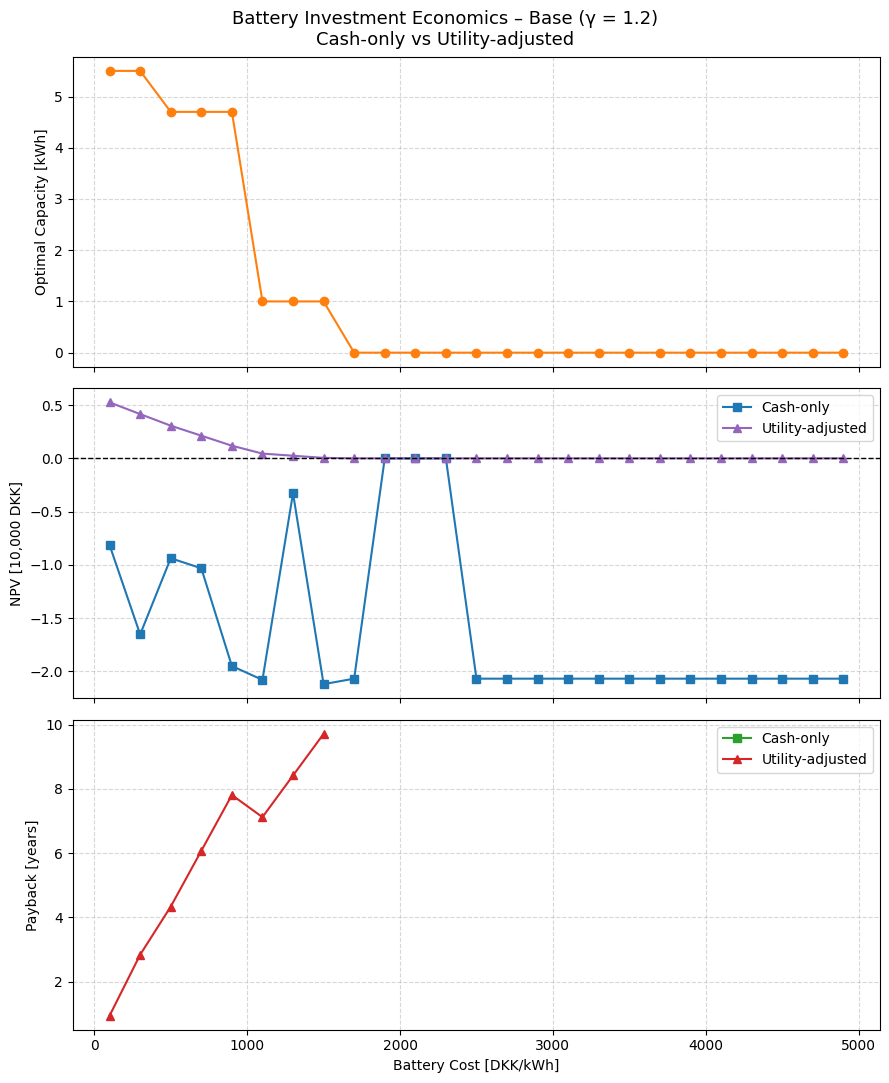

In [190]:
fig, axes = plt.subplots(3, 1, figsize=(9, 11), sharex=True)

axes[0].plot(df_base["C_batt"], df_base["E_cap"], "o-", color="tab:orange")
axes[0].set_ylabel("Optimal Capacity [kWh]")
axes[0].grid(True, ls="--", alpha=0.5)

axes[1].plot(df_base["C_batt"], df_base["NPV_cash"]/1e4, "s-", label="Cash-only", color="tab:blue")
axes[1].plot(df_base["C_batt"], df_base["NPV_total"]/1e4, "^-", label="Utility-adjusted", color="tab:purple")
axes[1].axhline(0, color="black", ls="--", lw=1)
axes[1].set_ylabel("NPV [10,000 DKK]")
axes[1].legend()
axes[1].grid(True, ls="--", alpha=0.5)

axes[2].plot(df_base["C_batt"], df_base["payback_cash"], "s-", label="Cash-only", color="tab:green")
axes[2].plot(df_base["C_batt"], df_base["payback_total"], "^-", label="Utility-adjusted", color="tab:red")
axes[2].set_xlabel("Battery Cost [DKK/kWh]")
axes[2].set_ylabel("Payback [years]")
axes[2].legend()
axes[2].grid(True, ls="--", alpha=0.5)

fig.suptitle("Battery Investment Economics – Base (γ = 1.2)\nCash-only vs Utility-adjusted", fontsize=13)
plt.tight_layout()
plt.show()

In [192]:
# --- Filter and rename relevant columns ---
df_summary = df_base[["C_batt", "E_cap", "NPV_total", "payback_total"]].copy()

# Rename columns for clarity
df_summary.rename(columns={
    "C_batt": "Battery cost [DKK/kWh]",
    "E_cap": "Optimal capacity [kWh]",
    "NPV_total": "NPV (utility-adjusted) [DKK]",
    "payback_total": "Payback period [years]"
}, inplace=True)

# Round for readability
df_summary = df_summary.round({
    "Battery cost [DKK/kWh]": 0,
    "Optimal capacity [kWh]": 2,
    "NPV (utility-adjusted) [DKK]": 1,
    "Payback period [years]": 2
})

display(df_summary[df_summary["Optimal capacity [kWh]"] > 0])

,Battery cost [DKK/kWh],Optimal capacity [kWh],NPV (utility-adjusted) [DKK],Payback period [years]
0,100,5.5,5255.9,0.95
1,300,5.5,4155.9,2.84
2,500,4.7,3067.4,4.34
3,700,4.7,2127.4,6.07
4,900,4.7,1187.4,7.81
5,1100,1.0,444.9,7.12
6,1300,1.0,244.9,8.41
7,1500,1.0,44.9,9.71


In [193]:
def run_utility_profitability_sweep(base, scenario, scenario_name, C_batt_values, r_ch, r_dis, gamma=1.2):
    """
    Runs profitability analysis for one scenario across battery cost values.
    Returns a DataFrame with only utility-adjusted metrics.
    """
    results = evaluate_profitability_split(base, scenario, C_batt_values, r_ch, r_dis, gamma)
    df = results[["C_batt", "E_cap", "NPV_total", "payback_total"]].copy()
    df["Scenario"] = scenario_name
    return df

In [194]:
# --- Parameters ---
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']
C_batt_values = np.arange(100, 2001, 200)
gamma = 1.2  # discomfort weight

# --- Run for selected scenarios ---
scenarios_to_run = ["Base", "Spike", "No export"]

dfs_all = []
for sc_name in scenarios_to_run:
    df = run_utility_profitability_sweep(base, scenarios[sc_name], sc_name, C_batt_values, r_ch, r_dis, gamma)
    dfs_all.append(df)

df_all = pd.concat(dfs_all, ignore_index=True)
display(df_all.head())

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x6088127c
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+03, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 2
      59    1.0942729e+05   0.000000e+00   0.000000e+00      0s

Solved in 59 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.094272920e+05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 

,C_batt,E_cap,NPV_total,payback_total,Scenario
0,100,5.5,5255.909,0.947311,Base
1,300,5.5,4155.909,2.841932,Base
2,500,4.7,3067.403,4.337872,Base
3,700,4.7,2127.403,6.073021,Base
4,900,4.7,1187.403,7.808169,Base


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x6088127c
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+03, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.02s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 2
      59    1.0942729e+05   0.000000e+00   0.000000e+00      0s

Solved in 59 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.094272920e+05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 

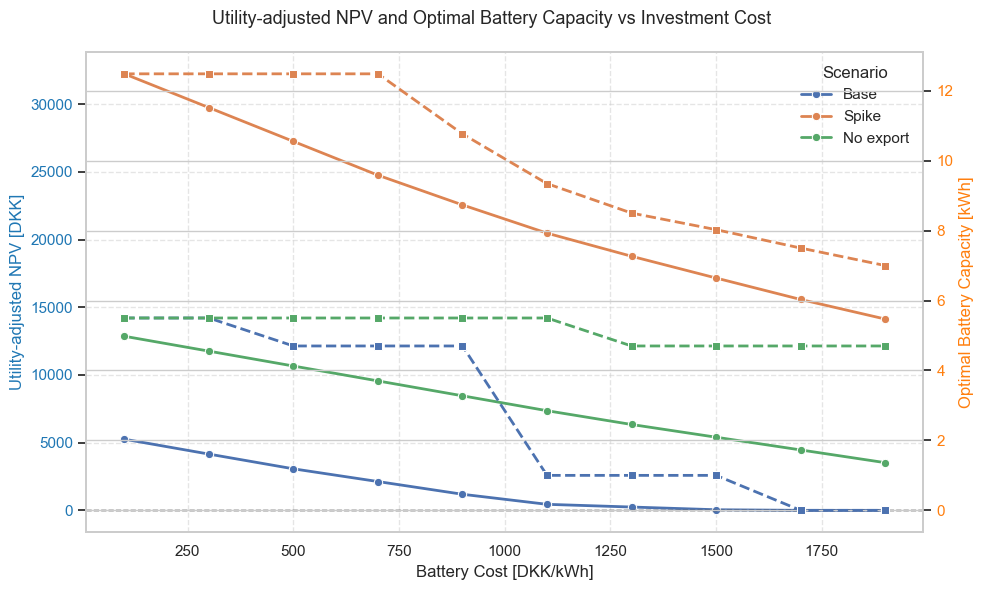

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parameters ---
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']
C_batt_values = np.arange(100, 2001, 200)
gamma = 1.2

# --- Scenarios to compare ---
scenarios_to_run = ["Base", "Spike", "No export"]

# --- Run profitability sweep for all scenarios ---
dfs_all = []
for sc_name in scenarios_to_run:
    df = run_utility_profitability_sweep(base, scenarios[sc_name], sc_name, C_batt_values, r_ch, r_dis, gamma)
    dfs_all.append(df)

df_all = pd.concat(dfs_all, ignore_index=True)

# --- Plot setup ---
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.set(style="whitegrid")

# --- Left y-axis: NPV ---
sns.lineplot(
    data=df_all,
    x="C_batt",
    y="NPV_total",
    hue="Scenario",
    marker="o",
    lw=2,
    ax=ax1
)
ax1.axhline(0, color="black", linestyle="--", linewidth=1)
ax1.set_xlabel("Battery Cost [DKK/kWh]", fontsize=12)
ax1.set_ylabel("Utility-adjusted NPV [DKK]", fontsize=12, color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(True, linestyle="--", alpha=0.5)

# --- Right y-axis: Capacity ---
ax2 = ax1.twinx()
sns.lineplot(
    data=df_all,
    x="C_batt",
    y="E_cap",
    hue="Scenario",
    marker="s",
    lw=2,
    ax=ax2,
    legend=False,  # avoid double legends
    linestyle="dashed"
)
ax2.set_ylabel("Optimal Battery Capacity [kWh]", fontsize=12, color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")

# --- Combined legend ---
handles1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(handles1, labels1, title="Scenario", loc="upper right", frameon=False)

# --- Formatting ---
fig.suptitle("Utility-adjusted NPV and Optimal Battery Capacity vs Investment Cost", fontsize=13)
fig.tight_layout()
plt.show()

In [201]:
# --- Parameters ---
r_ch = appliance_params['storage'][0]['max_charging_power_ratio']
r_dis = appliance_params['storage'][0]['max_discharging_power_ratio']
C_batt_values = [100, 500, 1000, 2000, 3000]   # representative investment costs
gamma = 1.2
scenarios_to_run = ["Base", "Spike", "No export"]

# --- Run profitability analysis ---
dfs_all = []
for sc_name in scenarios_to_run:
    df = run_utility_profitability_sweep(base, scenarios[sc_name], sc_name, C_batt_values, r_ch, r_dis, gamma)
    dfs_all.append(df)

df_all = pd.concat(dfs_all, ignore_index=True)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 241 columns and 554 nonzeros
Model fingerprint: 0x6088127c
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+03, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 62 rows and 78 columns
Presolve time: 0.00s
Presolved: 131 rows, 163 columns, 397 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0969425e+04   3.139315e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 2
      59    1.0942729e+05   0.000000e+00   0.000000e+00      0s

Solved in 59 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.094272920e+05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 

In [205]:
df_all

,C_batt,E_cap,NPV_total,payback_total,Scenario
0,100,5.500000,5255.909000,0.947311,Base
1,500,4.700000,3067.403000,4.337872,Base
2,1000,4.700000,717.403000,8.675744,Base
3,2000,0.000000,0.000000,NaN,Base
4,3000,0.000000,0.000000,NaN,Base
5,100,12.481481,32245.094506,0.372657,Spike
6,500,12.481481,27252.501914,1.863284,Spike
7,1000,10.629630,21496.522798,3.308715,Spike
8,2000,7.000000,13431.696667,5.103585,Spike
9,3000,5.500000,6854.220833,7.065104,Spike


In [210]:
# --- Select and clean relevant columns ---
df_summary = df_all[["Scenario", "E_cap", "C_batt", "NPV_total", "payback_total"]].copy()

# Round and rename
df_summary.rename(columns={
    "E_cap": "Optimal capacity [kWh]",
    "C_batt": "Battery cost [DKK/kWh]",
    "NPV_total": "NPV (utility-adjusted) [DKK]",
    "payback_total": "Payback [years]"
}, inplace=True)

df_summary = df_summary.round({
    "Optimal capacity [kWh]": 2,
    "Battery cost [DKK/kWh]": 0,
    "NPV (utility-adjusted) [DKK]": 0,
    "Payback [years]": 2
})

# Pivot table to have multi-level columns
df_pivot = df_summary.pivot(index="Battery cost [DKK/kWh]", columns="Scenario", values=["Optimal capacity [kWh]", "NPV (utility-adjusted) [DKK]", "Payback [years]"])

# Flatten column MultiIndex for LaTeX readability
df_pivot.columns = [f"{col[1]} {col[0].split()[0]}" for col in df_pivot.columns]
df_pivot = df_pivot.reset_index()

display(df_pivot.round(2))

,Battery cost [DKK/kWh],Base Optimal,No export Optimal,Spike Optimal,Base NPV,No export NPV,Spike NPV,Base Payback,No export Payback,Spike Payback
0,100,5.5,5.5,12.48,5256.0,12861.0,32245.0,0.95,0.41,0.37
1,500,4.7,5.5,12.48,3067.0,10661.0,27253.0,4.34,2.05,1.86
2,1000,4.7,5.5,10.63,717.0,7911.0,21497.0,8.68,4.10,3.31
3,2000,0.0,4.7,7.00,0.0,3053.0,13432.0,NaN,7.55,5.10
4,3000,0.0,1.0,5.50,0.0,516.0,6854.0,NaN,8.53,7.07
